## 1. 웹캠 켜기

In [1]:
import traitlets
import ipywidgets
from IPython.display import display
from jetbot import Camera, bgr8_to_jpeg

camera = Camera.instance(width=300, height=300)

#카메라로 찍은 frame 을 띄워줄 image 객체 생성, 크기를 맞출 필요는 없다.
image = ipywidgets.Image(format='jpeg', width=300, height=300) 
camera_link = traitlets.dlink((camera, 'value'), (image, 'value'), transform=bgr8_to_jpeg)

display(image)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

In [3]:
camera.stop()

In [ ]:
# 이미지 저장 테스트
image_shot = camera.value
cv2.imwrite('./checkboard_images/aptured_image.jpg', image_shot)
print("이미지를 저장했습니다.")

while(True):
    print("dd")
    time.sleep(1)


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-w6wx5yih because the default path (/home/jetbot/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


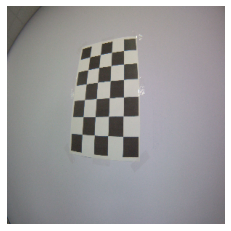

In [5]:
import cv2
from matplotlib import pyplot as plt

# 이미지 파일 경로
image_path = "./checkboard_images/captured_img_10.png"

# 이미지 읽기
image = cv2.imread(image_path)

# 이미지가 제대로 읽혔는지 확인
if image is not None:
    # BGR 이미지를 RGB로 변환
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 이미지 표시
    plt.imshow(image_rgb)
    plt.axis('off')  # 축 숨기기
    plt.show()
else:
    print("이미지를 읽을 수 없습니다.")


## 2. 이미지 캡쳐하기

In [4]:
# capture image 
import cv2
import time
img_counter=0
interval = 3    # 사진을 찍는 간격 (초 단위)

# is_running = camera.running
# if not is_running:
#     print("NOT found camera")

display(image)
while True:
    current_time = int(time.time())
    print(current_time)
    frame = camera.value
    
    img_name="./test/captured_img_{}.png".format(img_counter)
    cv2.imwrite(img_name,frame)
    print("{}written!".format(img_name))
    img_counter+=1
    if(img_counter == 5):
        break
    time.sleep(3)
    
camera.stop()

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

1715840404
./test/captured_img_0.pngwritten!
1715840407
./test/captured_img_1.pngwritten!
1715840410
./test/captured_img_2.pngwritten!
1715840414
./test/captured_img_3.pngwritten!
1715840417
./test/captured_img_4.pngwritten!


In [19]:
image_np = cv2.imread('./checkboard_images/captured_img_7.png', cv2.IMREAD_UNCHANGED)
print(f"이미지 크기: {image_np.shape}")
print(image_np)
camera.stop()

이미지 크기: (300, 300, 3)
[[[ 81  91  90]
  [ 80  85  98]
  [ 83  89  95]
  ...
  [133 137 137]
  [139 138 139]
  [135 134 141]]

 [[ 80  91  90]
  [ 72  87  89]
  [ 84  89  81]
  ...
  [129 137 138]
  [137 136 138]
  [135 136 145]]

 [[ 86  93  90]
  [ 76  89  92]
  [ 86  90  96]
  ...
  [137 137 144]
  [142 135 141]
  [137 131 141]]

 ...

 [[  0   0   0]
  [  0   0   2]
  [  0   0   0]
  ...
  [119 115 123]
  [123 117 127]
  [123 117 121]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [119 114 122]
  [122 120 125]
  [124 119 131]]

 [[  0   4   0]
  [  0   0   7]
  [  0   0   2]
  ...
  [124 118 124]
  [114 116 124]
  [113 114 117]]]


## 3. Calibration으로 파라미터, 왜곡계수 찾기

In [18]:
# find camera intrinsic parameters ! 
import numpy as np
import cv2
import glob

# 체스판 이미지에서 코너를 검출하기 위한 설정 (세로 점 개수, 가로 점 개수)
CHESSBOARD_SIZE = (6, 4)        
CHESSBOARD_FLAGS = cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_NORMALIZE_IMAGE

# 카메라 캘리브레이션을 위한 샘플 이미지 경로
CALIBRATION_IMAGES = glob.glob('checkboard_images/*.png')
print(CALIBRATION_IMAGES)

# 체스판 코너를 검출하기 위한 객체 생성
chessboard_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,40, 0.001)

# 체스판 코너를 검출하기 위한 함수
def find_chessboard_corners(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, CHESSBOARD_SIZE, None, CHESSBOARD_FLAGS)
    if ret:
        corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), chessboard_criteria)
    return ret, corners

# 캘리브레이션에 필요한 체스판 코너 검출 결과
object_points = []
image_points = []

# 체스판 코너 검출
for image_path in CALIBRATION_IMAGES:
    ret, corners = find_chessboard_corners(image_path)
    if ret:
        object_points.append(np.zeros((CHESSBOARD_SIZE[0] * CHESSBOARD_SIZE[1], 3), np.float32))
        object_points[-1][:, :2] = np.mgrid[0:CHESSBOARD_SIZE[0], 0:CHESSBOARD_SIZE[1]].T.reshape(-1, 2)
        image_points.append(corners)

# 카메라 캘리브레이션
image_size = cv2.imread(CALIBRATION_IMAGES[0]).shape[:2]
ret, camera_matrix, distortion_coefficients, rotation_vectors, translation_vectors = cv2.calibrateCamera(
    object_points, image_points, image_size, None, None
)
print("Camera matrix:\n", camera_matrix)
print("Distortion coefficients:\n", distortion_coefficients)
np.save("./parameters/intrinsic_parameter.npy",camera_matrix)
np.save("./parameters/distortion_coefficients.npy",distortion_coefficients)
# 결과 출력


['checkboard_images/captured_img_26.png', 'checkboard_images/captured_img_20.png', 'checkboard_images/captured_img_9.png', 'checkboard_images/captured_img_7.png', 'checkboard_images/captured_img_3.png', 'checkboard_images/captured_img_13.png', 'checkboard_images/captured_img_22.png', 'checkboard_images/captured_img_21.png', 'checkboard_images/captured_img_4.png', 'checkboard_images/captured_img_25.png', 'checkboard_images/captured_img_17.png', 'checkboard_images/captured_img_5.png', 'checkboard_images/captured_img_14.png', 'checkboard_images/captured_img_18.png', 'checkboard_images/captured_img_23.png', 'checkboard_images/captured_img_12.png', 'checkboard_images/captured_img_16.png', 'checkboard_images/captured_img_10.png', 'checkboard_images/captured_img_6.png', 'checkboard_images/captured_img_24.png', 'checkboard_images/captured_img_15.png', 'checkboard_images/captured_img_8.png', 'checkboard_images/captured_img_11.png', 'checkboard_images/captured_img_19.png']
Camera matrix:
 [[143.

## 4. Calibration을 이용해 얻은 계수로 왜곡 보정 테스트하기

In [ ]:
import cv2
import numpy as np
import time
import traitlets
import ipywidgets as widgets
from IPython.display import display
from jetbot import Camera, bgr8_to_jpeg
import threading

# JetBot 카메라 인스턴스 생성
camera = Camera.instance(width=300, height=300)

# 디스플레이 위젯 생성
image_widget = widgets.Image(format='jpeg', width=300, height=300)
display(image_widget)

# 파라미터 가져옴
camera_matrix_file = "./parameters/intrinsic_parameter.npy"
dist_coeffs_file = "./parameters/distortion_coefficients.npy"
camera_matrix = np.load(camera_matrix_file)
dist_coeffs = np.load(dist_coeffs_file)
print("camera_matrix", camera_matrix)
print("dist_coeffs", dist_coeffs)

# 프레임에 점을 찍고 HSV 값을 표시하는 함수
def update_image(change):
    frame = camera.value
    # 왜곡 보정
    undistorted = cv2.undistort(frame, camera_matrix, dist_coeffs)
    # 위젯에 이미지 표시
    image_widget.value = bgr8_to_jpeg(undistorted)

# 카메라 프레임이 변경될 때마다 함수를 호출하여 업데이트
camera.observe(update_image, names='value')

# 카메라 중지 (Jupyter Notebook을 중지하면 자동으로 호출됨)
def stop_camera():
    camera.unobserve(update_image, names='value')
    camera.stop()

# 주피터 종료 시 카메라 중지
import atexit
atexit.register(stop_camera)

Image(value=b'', format='jpeg', height='300', width='300')

camera_matrix [[143.1741169    0.         144.52728132]
 [  0.         189.22983068 142.75844376]
 [  0.           0.           1.        ]]
dist_coeffs [[-3.41473631e-01  1.67474878e-01  4.81115840e-05  1.18391685e-03
  -5.85043848e-02]]


In [6]:
import cv2
import numpy as np
import time
import traitlets
import ipywidgets as widgets
from IPython.display import display
from jetbot import Camera, bgr8_to_jpeg
import ipywidgets as widgets

camera = Camera.instance(width=300, height=300)
image = ipywidgets.Image(format='png', width=300, height=300) 
camera_link = traitlets.dlink((camera, 'value'), (image, 'value'), transform=bgr8_to_jpeg)
camera.stop()

In [8]:
import cv2
import numpy as np
from pop import Util

Util.enable_imshow()

# 이미지 파일 경로
IMAGE_PATH = "image/captured_img_17.png"

# 내부 파라미터 파일 경로
CAMERA_MATRIX_PATH = "intrinsic_parameters/camera_matrix.npy"
DISTORTION_COEFFICIENTS_PATH = "intrinsic_parameters/distortion_coefficients.npy"

# 이미지 불러오기
original_image = cv2.imread(IMAGE_PATH)

# 내부 파라미터 로드
camera_matrix = np.load(CAMERA_MATRIX_PATH)
distortion_coefficients = np.load(DISTORTION_COEFFICIENTS_PATH)

# 이미지 캘리브레이션
undistorted_image = cv2.undistort(original_image, camera_matrix, distortion_coefficients)

cv2.imwrite("undistorted_Image.png",undistorted_image)

cv2.imshow("Original Image",original_image)
cv2.imshow("undistorted_Image",undistorted_image)
# 해상도 출력
print("Original image resolution:", original_image.shape[:2])
print("Undistorted image resolution:", undistorted_image.shape[:2])

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

Original image resolution: (480, 640)
Undistorted image resolution: (480, 640)


In [1]:
ㅍ
camera.stop()

NameError: name 'camera' is not defined